# Political Parties of the USA - an exploratory data & text analysis of wikipedia pages

## Introduction

In this notebook, we are going to do an exploratory data & text analysis. The data to be analyzed comes from Wikipedia and consists of pages that either belong to the category [Democratic Party (United States)](https://en.wikipedia.org/wiki/Category:Democratic_Party_(United_States)) or the [Republican Party (United States)](https://en.wikipedia.org/wiki/Category:Republican_Party_(United_States)). Although both categories are about a political party, both have [different standings on several political issues and values](https://www.diffen.com/difference/Democrat_vs_Republican) that seem to be an exciting starting point for analysis, as we assume that differences will also be visible in the wiki pages of every category that express themselves by different words used, vocabulary and central topics (persons, organizations, places etc.). Text analysis helps us here and makes it possible to gather insights from text. In this notebook, we will therefore try to achieve the following goals and answer the following questions:



#### **🎯 Goals**
* Extract data from the wikipedia-api, clean the data, and transform them to be ready for analysis.
* Show different methods for analyzing text data by applying them to our wiki pages and capture insights in form of visualizations.
* Compare the wiki pages of the two articles and find insights about similarities and differences.



#### **❓ Questions**

Based on our assumptions, we want to answer the following questions:
* What are the differences and similarities between the wiki pages for every party?
* Wiki pages should be written objectively. However, see that a positive or negative polarity is visible in the texts?
* Does the vocabulary and vocabulary range of both categories highly differ?
* What are the most commonly mentioned topics or words used for every party's wiki pages?
* Which persons play a major role in the wiki pages of both parties?


## Setup

Before we start, we need to install the `wikipedia-api` and import the necessary libraries. A deeper understanding of the usage of the `wikipedia-api` can be got by consulting its [documentation](https://pypi.org/project/Wikipedia-API/).

In [ ]:
# Install wikipedia-api
!pip install wikipedia-api

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Import needed packages

# data preparation and handling
import wikipediaapi
import numpy as np
import pandas as pd

# visualisation libraries
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from wordcloud import WordCloud, STOPWORDS

# nlp libraries
import spacy
nlp = spacy.load("en_core_web_sm")
from textblob import TextBlob
import nltk
nltk.download('punkt') # Needed for tokenization


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## Preprocessing 

In order to analyse the data we need a data frame that consist of the text of the article in a data frame. In order to get this, we have to do the following steps:

1. Get data from wikipedia-api and store it in a data frame
2. Concatenate both data frames into one data frame
3. Take a closer look at any missing data and evaluate how we deal with it
4. Manipulate the data with additional columns needed for analysis

### 1. Getting the data from the wikipedia-api

In [ ]:
# Set language
wiki = wikipediaapi.Wikipedia('en')

# Get page for category
# First category - Democratic Pary
democrat_category = wiki.page("Category:Democratic_Party_(United_States)")
# Second category - Republican Party
republican_category = wiki.page("Category:Republican_Party_(United_States)")

In [ ]:
# Create function to create a DataFrame for every article (adapted from https://pypi.org/project/Wikipedia-API/)
def create_dataframe(wiki_category, category_name, level=0):
  """
  Create a dataframe from a wikipediaapi.WikipediaPage-object.
  Columns include title, summary, text, category_name.
  Will only include Text until References section and without See also section.
  """

  dictionary_list = []
  for category in wiki_category.categorymembers.values():
    d = {}
    if category.ns == 0:
      d["title"] = category.title
      d["summary"] = category.summary
      
      # Only add the text until the References section and do not include See also section
      text = ""
      for section in category.sections:
        if section.title == "References":
          break
        elif section.title == "See also":
          pass
        else:
          text_section = section.title + " " + section.text
          text += text_section

      # Add na if no text
      if len(text) == 0:
        d["text"] = None
      else:
        d["text"] = text
      d["category_name"] = category_name
      
      dictionary_list.append(d)
    else:
      continue
  
  print(f"Found {len(dictionary_list)} pages")
  df = pd.DataFrame(dictionary_list)

  return df

In [ ]:
democrat_df = create_dataframe(democrat_category, category_name="Democratic Party", level=0)
democrat_df.head()

Found 58 pages


,title,summary,text,category_name
0,Democratic Party (United States),The Democratic Party is one of the two major c...,History Democratic Party officials often trace...,Democratic Party
1,List of state parties of the Democratic Party ...,This is a list of official state and territori...,State and territorial organizations Democratic...,Democratic Party
2,100-Hour Plan,The 100-Hour Plan was a United States Democrat...,Origin The origin for the name of the plan is ...,Democratic Party
3,AKPD Message and Media,AKPD Message and Media is an American politica...,Notable clients Barack Obama during the 2008 U...,Democratic Party
4,American Samoa Democratic Party,American Samoa Democratic Party is the America...,Party officials Election took place on October...,Democratic Party


In [ ]:
republican_df = create_dataframe(republican_category, category_name="Republican Party", level=0)
republican_df.head()

Found 56 pages


,title,summary,text,category_name
0,Republican Party (United States),"The Republican Party, also referred to as the ...",History Name and symbols The party's founding ...,Republican Party
1,2006 Republican Party scandals,The 2006 Republican Party scandals resulted in...,List of politicians 2006 elections Republican ...,Republican Party
2,African American Engagement Office,An African American Engagement Office is a Uni...,None,Republican Party
3,Anti-Nebraska movement,The Anti-Nebraska movement was a political ali...,History Most in the anti-Nebraska movement con...,Republican Party
4,Appeal of the Independent Democrats,The Appeal of the Independent Democrats (the f...,"Background The ""Appeal of the Independent Demo...",Republican Party


In [ ]:
# We have 59 democrat and 56 republican wiki pages
len(democrat_df), len(republican_df)

(58, 56)

By creating our function `create_dataframe()` we were able to extract the sections of interest for our analysis and store them in a data frame. For example, we only added the text until the *References-section* and did not include the *See-also-section* for every wiki page. 

In total, we have **58 wiki pages** that belong to the category of the **Democratic Party** and **56 wiki pages** that belong to the category of the **Republican Party**.

### 2. Concatenate both data frames into one data frame

Next, we will concatenate both data frames into one data frame, in order to facilitate the upcoming cleaning and transformation.

In [ ]:
# Concatenate both data frames into one dataf rame
us_party_df = pd.concat([democrat_df, republican_df], ignore_index=True)
us_party_df.head()

,title,summary,text,category_name
0,Democratic Party (United States),The Democratic Party is one of the two major c...,History Democratic Party officials often trace...,Democratic Party
1,List of state parties of the Democratic Party ...,This is a list of official state and territori...,State and territorial organizations Democratic...,Democratic Party
2,100-Hour Plan,The 100-Hour Plan was a United States Democrat...,Origin The origin for the name of the plan is ...,Democratic Party
3,AKPD Message and Media,AKPD Message and Media is an American politica...,Notable clients Barack Obama during the 2008 U...,Democratic Party
4,American Samoa Democratic Party,American Samoa Democratic Party is the America...,Party officials Election took place on October...,Democratic Party


In [ ]:
# Wee have 114 articles and 4 columns
us_party_df.shape

(114, 4)

Concatenation worked, and we have now a single data frame with 4 features and 114 rows (wiki pages).

### 3. Take a closer look at any missing data and evaluate how we deal with it

Next, we inspect the data frame for any missing values. As we can see from calling the `.info()`-method of our data frame, we have missing values in the text-column of our data frame. Visualizing the missing values in a heatmap helps us see better where they are located.

In [ ]:
# Inspect data
us_party_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114 entries, 0 to 113
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   title          114 non-null    object
 1   summary        114 non-null    object
 2   text           104 non-null    object
 3   category_name  114 non-null    object
dtypes: object(4)
memory usage: 3.7+ KB


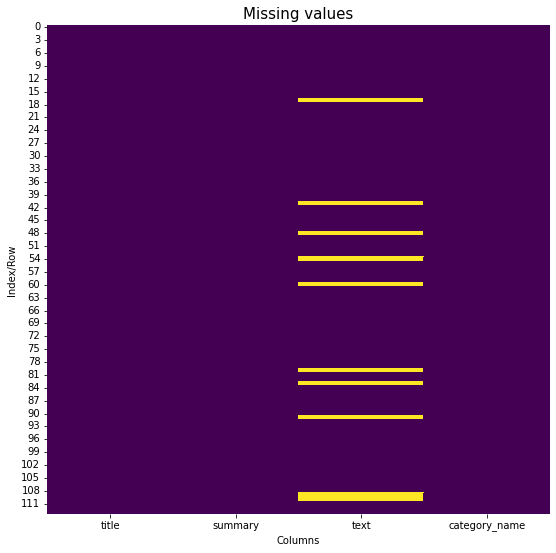

In [ ]:
# Inspect NaN values
plt.figure(figsize=(9, 9))
sns.heatmap(us_party_df.isna(), cmap="viridis", cbar=False)
plt.title("Missing values", fontsize=15)
plt.ylabel("Index/Row", fontsize=10)
plt.xlabel("Columns", fontsize=10);

In every analysis, it's important to familiarize yourselves with the data. Therefore, let's randomly take a closer look at wiki pages where the text section is missing.

In [ ]:
# Randomly select a page that has no text
np.random.seed(42)
for i in range(4):
  na_indexes = us_party_df.loc[us_party_df.isna().any(axis=1)].index
  random_article = np.random.choice(na_indexes)
  print(us_party_df.iloc[random_article])

title                       Independent Republican (United States)
summary          In the politics of the United States, Independ...
text                                                          None
category_name                                     Republican Party
Name: 83, dtype: object
title                       Vice Chairman of the Democratic Caucus
summary          The Vice Chair of the Democratic Caucus is the...
text                                                          None
category_name                                     Democratic Party
Name: 54, dtype: object
title                                       Negro Republican Party
summary          The Negro Republican Party was one name used, ...
text                                                          None
category_name                                     Republican Party
Name: 91, dtype: object
title                           African American Engagement Office
summary          An African American Engagement Office is

In order to understand why we have missing text data we can take a closer look at the corresponding pages of the randomly selected entries with missing text data:

 * [Independent Republican (United States)](https://en.wikipedia.org/wiki/Independent_Republican_(United_States))
 * [Vice Chairman of the Democratic Caucus](https://en.wikipedia.org/wiki/Vice_Chairman_of_the_Democratic_Caucus)
 * [Negro Republican Party](https://en.wikipedia.org/wiki/Negro_Republican_Party)
 * [African American Engagement Office](https://en.wikipedia.org/wiki/African_American_Engagement_Office)

Inspecting the articles makes it clear that the pages only consist of a title and a summary and therefore don't have a text section (*besides see also and references that we are not interested in*). Therefore, missing values correspond to rather shorter articles that don't have a text section. Let's clean this up by imputing an empty string for every missing value in the text column.

In [ ]:
# Replace missing values with empty string
us_party_df["text"] = us_party_df["text"].fillna("")

In [ ]:
# Check if there are still missing values --> there are none left
us_party_df.isna().sum()

title            0
summary          0
text             0
category_name    0
dtype: int64

### 4. Manipulate the data with additional columns needed for analysis

We want to analyze the whole text of every page. This will be easier when we put the whole text (title, summary, text) into one column. Additionally, we want to clean the text in a way that we can compare it easier to each other.

Let's start by creating a new column that consists of the whole text of a wiki page.

In [ ]:
# Create new column of the whole text per page
us_party_df["full_text"] = us_party_df[["title", "summary", "text"]].apply(" ".join, axis=1) 

In [ ]:
# Let's take a closer look at the full text before proceeding.
# Therefore let's randomly select and display some
# Randomly select a page that has no text
np.random.seed(42)
for i in range(3):
  random_article_index = np.random.choice(len(us_party_df)+1)
  random_article = us_party_df.iloc[random_article_index]
  title = random_article.loc["title"]
  full_text = random_article.loc["full_text"]
  print(f"Title: {title} \n")
  print(f"Full Text: {full_text} \n")
  print(50 * "*")


Title: Republican Revolution 

Full Text: Republican Revolution The "Republican Revolution", "Revolution of '94", or "Gingrich Revolution" are political slogans that refer to the Republican Party (GOP) success in the 1994 U.S. mid-term elections, which resulted in a net gain of 54 seats in the House of Representatives, and a pick-up of eight seats in the Senate. On November 9, 1994, the day after the election, Senator Richard Shelby of Alabama, a conservative Democrat, changed parties, becoming a Republican; on March 3, 1995, Colorado Senator Ben Nighthorse Campbell switched to the Republican side as well, increasing the GOP Senate majority.Rather than campaigning independently in each district, Republican candidates chose to rally behind a single national program and message fronted by Georgia congressman and House Republican whip Newt Gingrich. They alleged that President Bill Clinton was not the "New Democrat" he claimed to be during his 1992 campaign, but was a "tax and spend" libe

The full text looks already good. However, there are a few things we need to do in order to increase the comparability of the texts and make them tidy.

* Change everything to lowercase 
* Remove any new line characters (`\n`)
* Lemmatize the words in the full texts

> 💡 **Key insight:** `Lemmatization` - "*Lemmatization usually refers to doing things properly with the use of a vocabulary and morphological analysis of words, normally aiming to remove inflectional endings only and to return the **base or dictionary form of a word**, which is known as the lemma*" (see: https://nlp.stanford.edu/IR-book/html/htmledition/stemming-and-lemmatization-1.html)
 
Having a text with its words in the dictionary representation (lemmatized) offers us then the possibility to inspect the vocabulary range of every wiki page (which we will do later). 

In [ ]:
# Change whole text to lowercase
us_party_df["full_text"] = us_party_df["full_text"].str.lower()

# Remove any possible double or more whitespace and remove new line charaters
us_party_df["full_text"] = us_party_df["full_text"].apply(lambda x: x.replace("\n", " "))

# Lemmatize the text (see: https://spacy.io/usage/linguistic-features#lemmatization)
lemmatizer = nlp.get_pipe("lemmatizer")
us_party_df["full_text_lemmatized"] = us_party_df["full_text"].apply(lambda x: " ".join([token.lemma_ for token in nlp(x)]))

# Let's take a look at a sequence of the first full text and the lemmatized one
# (e.g. is --> be, parties --> party, founded --> found)
print("Full text:")
print(us_party_df["full_text"][0][:150])
print("Lemmatized full text:")
print(us_party_df["full_text_lemmatized"][0][:150])

Full text:
democratic party (united states) the democratic party is one of the two major contemporary political parties in the united states. founded in 1828, it
Lemmatized full text:
democratic party ( united states ) the democratic party be one of the two major contemporary political party in the united states . found in 1828 , it


> 💡 **Key insight:** We see that the words in the text are now lowercase and lemmatized. As a last step, we now want to remove stop words, since they add noise to our data and don't give any value to the text. We can achieve this by using the stop words set from `nlp.Defaults.stop_words` and using the `is_stop` property of our `spacy.tokens.doc.Doc` object. (see: https://stackabuse.com/removing-stop-words-from-strings-in-python/#usingthespacylibrary) 

In [ ]:
# Take a look at some stop words
print(list(nlp.Defaults.stop_words)[:10]), 
print(f"Total number of stop words: {len(nlp.Defaults.stop_words)}")

['few', 'while', 'latter', 'will', 'toward', 'hundred', 'too', '‘re', 'a', 'onto']
Total number of stop words: 326


In [ ]:
# Create function to filter out stop words
def stop_word_remover(text: str):
  """
  Removes stop words from a string.
  """
  doc = nlp(text)
  new_text_list = []
  
  for token in doc:
    if token.is_stop:
      continue
    else:
      new_text_list.append(token.text)

  return " ".join(new_text_list)

In [ ]:
# Create a new column of the full text where the stop words are removed
us_party_df["full_text_lemmatized_stopword_removed"] = us_party_df["full_text_lemmatized"].apply(lambda x: stop_word_remover(x))

In [ ]:
# Let's again take a look at a sequence of the first full text and the lemmatized + stop words removed one
# (e.g. is --> be, parties --> party, founded --> found)
print("Full text:")
print(us_party_df["full_text"][0][:150])
print("Lemmatized and stop words removed full text:")
print(us_party_df["full_text_lemmatized_stopword_removed"][0][:150])

Full text:
democratic party (united states) the democratic party is one of the two major contemporary political parties in the united states. founded in 1828, it
Lemmatized and stop words removed full text:
democratic party ( united states ) democratic party major contemporary political party united states . found 1828 , predominantly build martin van bur


By creating our own function we were able to remove the stop words from our full text. Let us now create additional columns for our analysis.

In [ ]:
# Add number of tokens (word count) for every text
us_party_df["num_token"] = us_party_df["full_text"].apply(lambda x: len(x.split()))
# Add number of tokens (word count) for every stop words removed text
us_party_df["num_token_stopword_removed"] = us_party_df["full_text_lemmatized_stopword_removed"].apply(lambda x: len(x.split()))

# Add the text length (in letters and spaces) of the full text to every page
us_party_df["text_length"] = us_party_df["full_text"].apply(lambda x: len(x))

# Add text length of summary
us_party_df["summary_length"] = us_party_df["summary"].apply(lambda x: len(x))
# Add number of tokens (word count) for summary
us_party_df["num_token_summary"] = us_party_df["summary"].apply(lambda x: len(x.split()))

# Add polarity score for full text and title (see: https://textblob.readthedocs.io/en/dev/quickstart.html)
us_party_df["polarity_full_text"] = us_party_df["full_text"].apply(lambda x: TextBlob(x).sentiment.polarity)
us_party_df["polarity_title"] = us_party_df["title"].apply(lambda x: TextBlob(x).sentiment.polarity)

# Add vocabulary range of wiki page for lemmatized full text
us_party_df["vocabulary_range"] = us_party_df["full_text_lemmatized"].apply(lambda x: len({word for word in x.split() if word.isalnum()}))

In [ ]:
# Let's take a look at the newly created columns
us_party_df[["num_token", "num_token_stopword_removed", "text_length", 
             "summary_length", "num_token_summary","polarity_full_text", 
             "polarity_title", "vocabulary_range"]].head(7)

,num_token,num_token_stopword_removed,text_length,summary_length,num_token_summary,polarity_full_text,polarity_title,vocabulary_range
0,2005,1503,13328,3956,599,0.081981,0.0,702
1,33,25,225,107,17,0.000000,0.0,16
2,942,723,6041,1330,213,0.176848,0.0,360
3,292,236,1961,1247,191,0.092584,0.0,155
4,102,87,653,146,24,-0.027778,0.0,57
5,414,369,2811,2006,304,0.103251,0.0,230
6,282,186,1813,466,73,0.049886,0.0,143


In [ ]:
# Inspect dataframe
us_party_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114 entries, 0 to 113
Data columns (total 15 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   title                                  114 non-null    object 
 1   summary                                114 non-null    object 
 2   text                                   114 non-null    object 
 3   category_name                          114 non-null    object 
 4   full_text                              114 non-null    object 
 5   full_text_lemmatized                   114 non-null    object 
 6   full_text_lemmatized_stopword_removed  114 non-null    object 
 7   num_token                              114 non-null    int64  
 8   num_token_stopword_removed             114 non-null    int64  
 9   text_length                            114 non-null    int64  
 10  summary_length                         114 non-null    int64  
 11  num_to

We now have cleaned our data frame and added additional variables that we will use for our analysis. Our **final data frame has 114 rows** (wiki pages and **15 variables**. We are, therefore, ready to start exploring our data set.

## Analysis

Now that we have cleaned our data and added new variables, we can start analyzing the different wiki pages. In order to holistically approach the analysis we will take a closer look at the following characteristics:

* Analysing the distributions of the wiki pages (inspecting potential outliers)
* Inspect the correlations of the variables
* Perform a text analysis by looking closer at the text content

### Analysing the distributions of the wiki pages

First of all, let us take a closer look at the text length of every wiki page and see how they are spread. We will do this by creating box plots that help us also identify potential outliers. If outliers are present, we will take a closer look at them.

In [ ]:
fig = px.box(us_party_df, y="num_token", color="category_name",
             custom_data=["title", "category_name"],
             title="Comparison of number of tokens per wiki page per party",
             color_discrete_map={"Democratic Party": "#0872AE",
                                 "Republican Party": "#BD2821"},
             template="seaborn")

fig.update_traces(
    hovertemplate="<br>".join([
        "Party: %{customdata[1]}",
        "Number of tokes: %{y}",
        "Title of wiki page: %{customdata[0]}"
    ])
)

fig.update_layout(
    legend_title="Party",
    yaxis_title="Number of tokens"
)
fig.show()

Inspecting the spread of number of tokens per wiki page, we see that both parties have almost the same spread. The Republican Party, however, has a slightly higher number of tokens when it comes to the lower and higher whiskers and the median value, which means that wiki pages of the Republican Party tend to have a bit more words than wiki pages of the Democratic Party. Additionally, we observe that both parties have outliers. Here, the wiki pages of the Democratic Party tend to be consisting of more tokens than the outliers of the Republican Party. Closer inspection of the outliers makes it visible that for both parties the two wiki pages with the most tokens are about the same topics, the history of the party and the south. As similar outliers are present in both of our categories, we will not remove them from our data set.

* Highest number of tokens - History pages:
  * [History of the Democratic Party (United States)](https://en.wikipedia.org/wiki/History_of_the_Democratic_Party_(United_States))
  * [History of the Republican Party (United States)](https://en.wikipedia.org/wiki/History_of_the_Republican_Party_(United_States))

* Second highest number of tokens - South pages:
  * [Solid South](https://en.wikipedia.org/wiki/Solid_South) - Democratic Party
  * [Southern Strategy](https://en.wikipedia.org/wiki/Southern_strategy) - Republican Party

Let's next take a closer look at the distributions of the other variables by using histograms.


In [ ]:
columns_to_be_ploted = ["num_token_stopword_removed", "text_length",
                        "summary_length", "num_token_summary",
                        "vocabulary_range", "polarity_full_text", 
                        "polarity_title"]

for column in columns_to_be_ploted:
  fig = px.histogram(us_party_df, x=column, 
                     color="category_name",
                     facet_col="category_name",
                     title=f"Distribution of {column} per party",
                     template="seaborn",
                     color_discrete_map={"Democratic Party": "#0872AE",
                                         "Republican Party": "#BD2821"},
                     height=320,
                     opacity=0.8)
  fig.update_layout(
    legend_title="Party",
    yaxis_title="Frequency"
  )

  fig.show()

In [ ]:
# Get titles of outliers of num_token_stopword_removed and text_length
us_party_df[(us_party_df['num_token_stopword_removed'] > 3000) | (us_party_df['text_length'] > 25000)][['title', 'category_name']]

,title,category_name
24,History of the Democratic Party (United States),Democratic Party
49,Solid South,Democratic Party
98,History of the Republican Party (United States),Republican Party
104,Southern strategy,Republican Party


Inspecting the histograms helps us understand the frequency distributions of our numerical variables. 

We see that `num_token_stopword_removed` (number of tokens without stop words) and `text_length` (length of the text in characters inclusive spaces) are right-skewed, which means that a majority of the wiki pages are located on the lower end of the distribution and are of shorter length of text and also number of tokens (without stop words). Additionally, this points to that the mean as measurement reflects an overestimation of the variable, as the higher values skew the distribution and therefore the central measurement (median) is located left of the mean. There are also outliers visible in both variables which are from the same texts. Inspecting them shows that they are the same wiki pages as we've already found out in the box plots of the number of tokens per text, which can be expected as a long text probably also results in more tokens.

Inspecting the length and the number of tokens in the summary shows that the distribution of the variables is also skewed, but additionally bi-modal. This means that there are two peaks visible, which could lead to the conclusion that we deal with two groups inside the variables. However, since the bimodality is not that strong, we will note dive deeper into this. 

When it comes to the vocabulary range of the pages, we see that the distribution for the Democratic Party has multiple peaks (multinomial) whereas the vocabulary range of the wiki pages of the Republican Party is right-skewed.

Taking a closer look at both polarity variables shows that the distribution of summarizing the polarity of a whole wiki page (`polarity_full_text`) resembles a normal distribution with outliers for the wiki pages of the Democratic Party on the lower and higher end. Both distributions seem to be centered at a polarity score of ~0.1. On the other hand, inspecting the distribution of the titles of the wiki pages shows that a large majority result in a polarity of 0. This means that the majority of titles do neither show positive nor negative sentiment. A closer inspection of the calculation of the polarity score seems therefore visible. However, before we dive into this in the text analysis section, let us first take a look at the correlations between the variables in our data.

### Inspect the correlations of the variables

Inspecting the correlation of the variables helps us understand their relationship and see if there are strong relationships available.

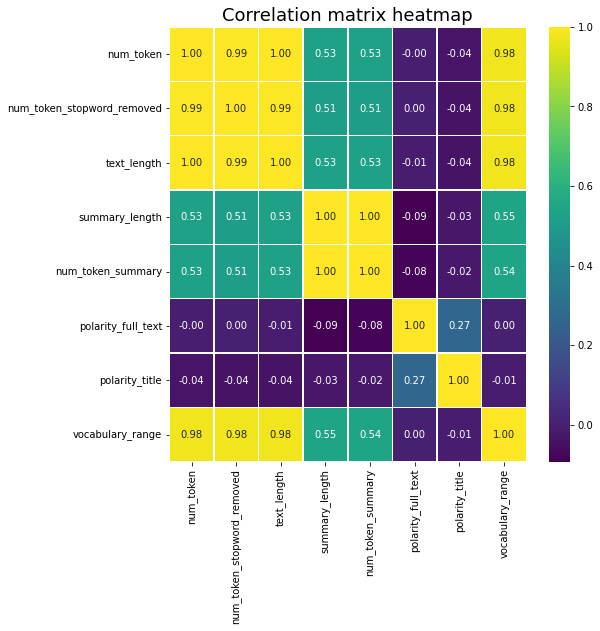

In [ ]:
# Creating correlation matrix plot (see: https://seaborn.pydata.org/generated/seaborn.heatmap.html)

# Compute correlation matrix 
corr = us_party_df.corr()

# Create fig and ax
plt.figure(figsize=(8, 8))

# Creating heatmap and map correlation matrix
fig = sns.heatmap(corr, cmap="viridis", annot=True,
                  fmt=".2f", linewidth=.5)

fig.axes.set_title("Correlation matrix heatmap",fontsize=18);

From the correlation matrix, we see that most of our variables have either a very strong correlation of >= 0.98 or are near 0. 

For the strong correlations, it's understandable as a long text leads to a higher number of tokens, whether it is with or without stop words. 

For the correlations that are near 0, we can see that the length of the text or the number of tokens has no influence on the polarity of an article. 

Lastly, we see that the length or number of words in the summaries has a medium correlation (~0.5) with the length or number of words in the text. Therefore, we can generally say that a long wiki page does not necessarily need to have a long summary.

### Text Analysis - Diving deeper into the text

Now that we have inspected the distributions and correlations of our variables, we can dive into the specific text analysis. Our aim is to a deeper understanding about aspects of the wiki pages and see if we can find differences when it comes to comparing the two categories. 

#### Polarity

Inspecting the polarity of a text helps to quantify the expressed sentiment of a text. A polarity score of 1 means that the text has a very positive sentiment, whereas 0 corresponds to a very negative sentiment. However, wiki pages should be written objectively and therefore have a sentiment score of near 0. As a first step, let us inspect the polarity scores of our wiki pages and see if there are differences when it comes to the categories.

In [ ]:
# Create scatterplot
fig = px.scatter(us_party_df, x="polarity_full_text", y="text_length",
                 size="vocabulary_range", color='category_name',
                 custom_data = ['title', 'category_name', 'vocabulary_range'],
                 title="Polarity compared to text length with vocabulary range as size",
                 template="seaborn",
                 color_discrete_map={"Democratic Party": "#0872AE",
                                     "Republican Party": "#BD2821"}, 
                 opacity=0.8)
  
fig.update_layout(
    legend_title="Party",
    yaxis_title="Text Length",
    xaxis_title="Polarity")

fig.update_traces(
    hovertemplate="<br>".join([
        "Party: %{customdata[1]}",
        "Text Length: %{y}",
        "Vocabulary Range: %{customdata[2]}",
        "Polarity: %{x:.2f}",
        "Title of wiki page: %{customdata[0]}"
    ])
)

fig.show()

In [ ]:
# Get median and mean polarity per party
print("Median Polarity:")
print(us_party_df.groupby('category_name')['polarity_full_text'].median())
print("Mean TTR:") 
print(us_party_df.groupby('category_name')['polarity_full_text'].mean())

Median Polarity:
category_name
Democratic Party    0.087641
Republican Party    0.084242
Name: polarity_full_text, dtype: float64
Mean TTR:
category_name
Democratic Party    0.087151
Republican Party    0.084405
Name: polarity_full_text, dtype: float64


> **💡 Key insight:** The mean and median polarity per category are both around 0.08, which means that in general there is almost no sentiment expressed in the wiki pages. Additionally, the mean and median per category are very near to each other. This means that we have a symmetrical distribution of polarity around 0.08 and in general can say that the wiki pages are written objectively. 
>
> Furthermore, we see that rather shorter texts of the Democratic Party are building the extremes of the polarity distribution of the wiki texts. On the other hand, text length and word range do not contribute a lot to the general polarity of an article as we've already seen in the correlation matrix. To therefore understand more how polarity is calculated we need to inspect more closely the documentation of the `sentiment.polarity`-property of the `TextBlob` object. Taking a look at the [documentation](https://textblob.readthedocs.io/en/dev/quickstart.html) does us not give a closer understanding of how polarity is calculated, we therefore have to take closer look at the [code itself](https://github.com/sloria/TextBlob/blob/eb08c120d364e908646731d60b4e4c6c1712ff63/textblob/_text.py) (line 661ff. & line 778ff.) and see that we find an explanation. `TextBlob` uses **synsets (sets of cognitive synonyms)** from [WordNet](https://wordnet.princeton.edu/) a large lexical database that returns a polarity value for a word. 

Let us, therefore, take a closer look at the polarity of the wiki page with the highest polarity score - [Vice Chairman of the Democratic Caucus](https://en.wikipedia.org/wiki/Vice_Chairman_of_the_Democratic_Caucus). For this, let's create a function that takes in the title of the wiki page and plots the words with a polarity value higher or lower than 0 of every word in the wiki page.





In [ ]:
# Create a function to visualise polarity of single words in sentence
def polarity_visualiser(wiki_page:str):
  """
  Takes in the title of the wiki page and plots the words with a polarity value 
  higher or lower than 0 of every word.
  """
  # Setup layout
  sns.set(rc={'figure.figsize':(35,3)})

  sentence = us_party_df.loc[us_party_df["title"] == wiki_page, "full_text"].item()

  # TextBlob model
  TextBlob(sentence).sentiment

  # Create dictionary with values for mapping
  words_dataframe = pd.DataFrame({
      "Sentence":["SENTENCE"] + [word for word in sentence.split() if (TextBlob(word).polarity > 0) or (TextBlob(word).polarity < 0)],
      "Sentiment":[TextBlob(sentence).polarity] + [TextBlob(word).polarity for word in sentence.split() if (TextBlob(word).polarity > 0) or (TextBlob(word).polarity < 0)]})
  # Set index and transpose
  words_dataframe = words_dataframe.set_index("Sentence").T

  heatmap = sns.heatmap(words_dataframe,center=0, annot=True, cmap = "PiYG")
  heatmap.set_title(f"Polarity values for word in {wiki_page} wiki page")

  return heatmap

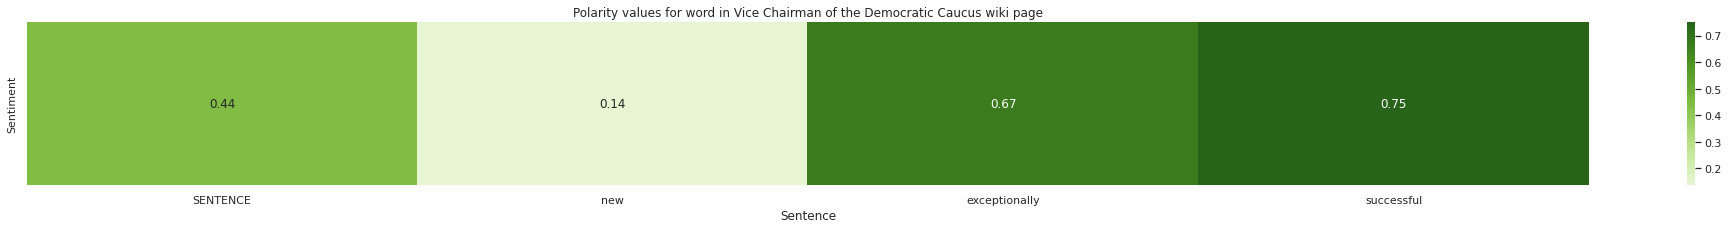

In [ ]:
# Filter for wiki page
polarity_visualiser("Vice Chairman of the Democratic Caucus");

We get the words of the article with the most positive polarity and see that it only has three words with a sentiment score that are all considered positive.

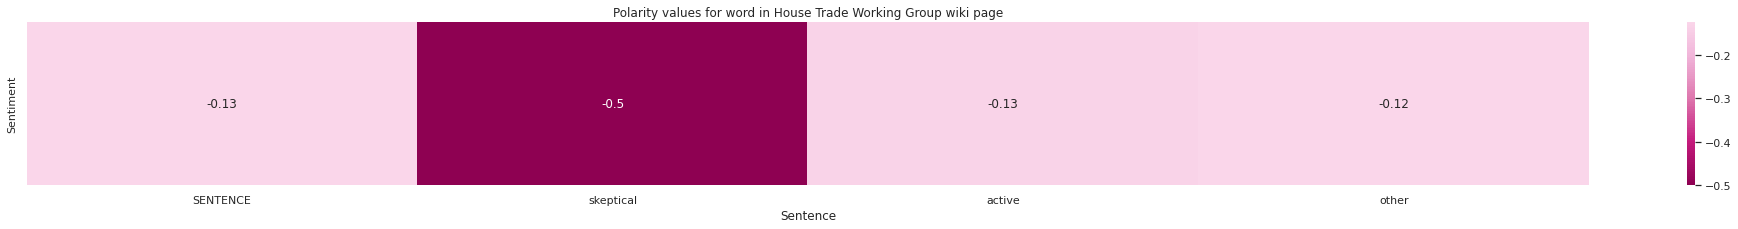

In [ ]:
# Filter for lowest value
polarity_visualiser("House Trade Working Group");

Inspecting the wiki page with the least polarity score, we see that it consists as well of only three words with a polarity value, but this time all with a negative value. 

Let us next inspect the polarity of a larger article. (Click on the plot to make it bigger)

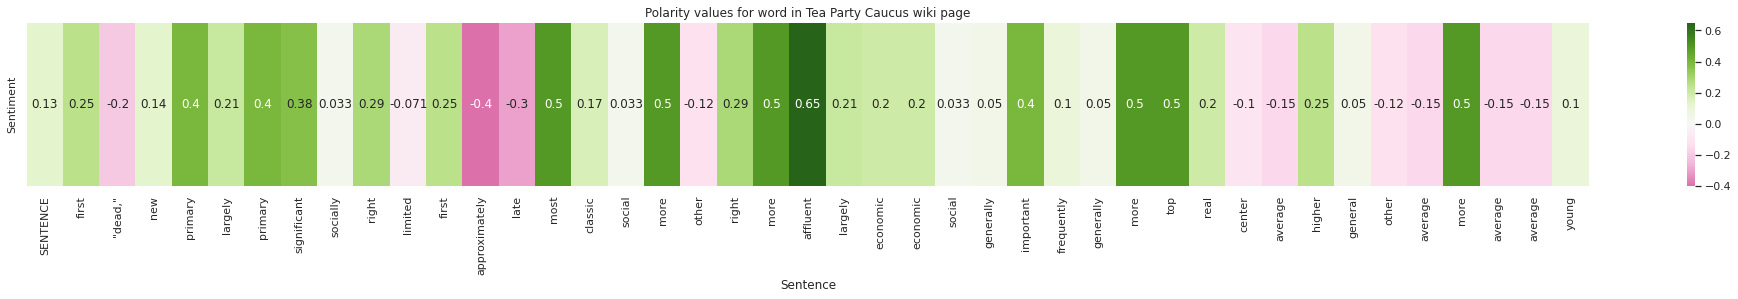

In [ ]:
polarity_visualiser("Tea Party Caucus");

We see that the text consists of multiple words of positive and negative sentiment, which equal each other out and lead to an overall polarity of 0.13.

Since we now have started looking closer at the words in an article, let us take a closer look at the used vocabulary.

#### Type-Token Ratio (TTR)

> 💡 **Key insight:** The type-token ratio helps us understand and quantify the variety of vocabulary used. It is calculated by dividing the number of unique words (number of types) by the total number of words (number of tokens). A TTR of 1 would therefore point to a very high richness in vocabulary and that every word only would be used once. Whereas a low TTR would mean that the same words are used over and over and that we don't have a huge variety in our vocabulary.
>
>**Type-Token Ratio:** *number of types/number of tokens*
>
> (See also: https://carla.umn.edu/learnerlanguage/spn/comp/activity4.html)



In [ ]:
# Calculate Type-Token Ratio
us_party_df["num_types"] = us_party_df["full_text"].apply(lambda x: len(set(x.split())))
us_party_df["type_token_ratio"] = round((us_party_df["num_types"]/us_party_df["num_token"]), 2)

In [ ]:
# Create scatterplot of TTR
fig = px.scatter(us_party_df, x="num_token", y="type_token_ratio",
                 color='category_name',
                 custom_data = ['title', 'category_name'],
                 title="Type-Token Ratio compared to Text Length",
                 template="seaborn",
                 color_discrete_map={"Democratic Party": "#0872AE",
                                     "Republican Party": "#BD2821"}, 
                 opacity=0.6)
  
fig.update_layout(
    legend_title="Party",
    yaxis_title="Type-Token Ratio",
    xaxis_title="Text Length")

fig.update_traces(
    hovertemplate="<br>".join([
        "Party: %{customdata[1]}",
        "Text Length: %{x}",
        "Title of wiki page: %{customdata[0]}"
    ]),
    marker=dict(size=11)
)

fig.show()

In [ ]:
# Calculate median and mean TTR per party
print("Median TTR:")
print(us_party_df.groupby('category_name')['type_token_ratio'].median())
print("Mean TTR:") 
print(us_party_df.groupby('category_name')['type_token_ratio'].mean())

Median TTR:
category_name
Democratic Party    0.555
Republican Party    0.530
Name: type_token_ratio, dtype: float64
Mean TTR:
category_name
Democratic Party    0.554483
Republican Party    0.533929
Name: type_token_ratio, dtype: float64


> 💡**Key insight:** Both categories have an almost identical TTR over all wiki pages, with the articles of the Republican Party scoring a marginal bit higher. As the main goal of a wiki page is to communicate knowledge, it is okay if it does not have the highest TTR value, since we are not expecting a poem. On the other hand, it is visible that with increasing text length (number of words) the TTR keeps on decreasing exponentially. This observance is a general rule with the TTR as the longer the input (words in the text), the higher the probability that this word was already used and therefore decreases the TTR.

#### Inspecting most frequent words and vocabulary range

Next, we want to take a closer look at the used words and vocabulary range of the wiki pages. We will therefore create word clouds for our wiki pages of the Democratic and Republican Party.

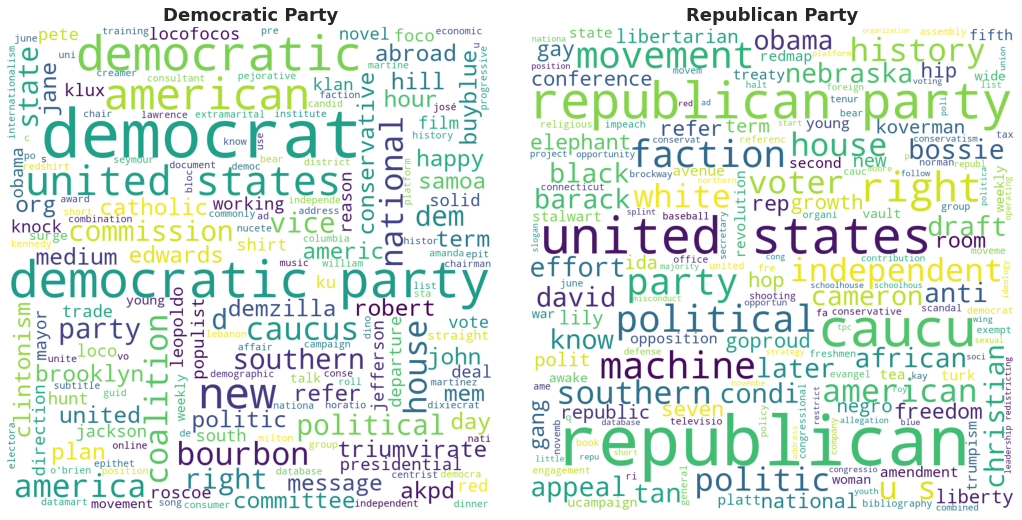

In [ ]:
# Create dataframe per categroy
democrats_df = us_party_df[us_party_df["category_name"] == "Democratic Party"]
republican_df = us_party_df[us_party_df["category_name"] == "Republican Party"]


# See documentation: https://amueller.github.io/word_cloud/generated/wordcloud.WordCloud.html (example adjusted from there)
# Also inspired from: https://www.datacamp.com/tutorial/wordcloud-python
wordcloud_democrats = WordCloud(width = 1000, height = 1000,
                      background_color='white',
                      min_font_size=10).generate(democrats_df["full_text_lemmatized_stopword_removed"].to_string())
wordcloud_republican = WordCloud(width = 1000, height = 1000,
                      background_color='white',
                      min_font_size=10).generate(republican_df["full_text_lemmatized_stopword_removed"].to_string())



# plot the wordcloud image
fig, ax = plt.subplots(1, 2, figsize = (15, 15))
ax[0].imshow(wordcloud_democrats)
ax[0].set_title("Democratic Party", fontdict={'fontsize': 18, 'fontweight' : 'bold'})
ax[0].axis("off")

ax[1].imshow(wordcloud_republican)
ax[1].set_title("Republican Party", fontdict={'fontsize': 18, 'fontweight' : 'bold'})
ax[1].axis("off")
plt.tight_layout(pad = 3)
plt.show()

We see that the party names are mentioned the most, as well as the word united states. Let's add them as stop words, so we can see the other topics/used words better.

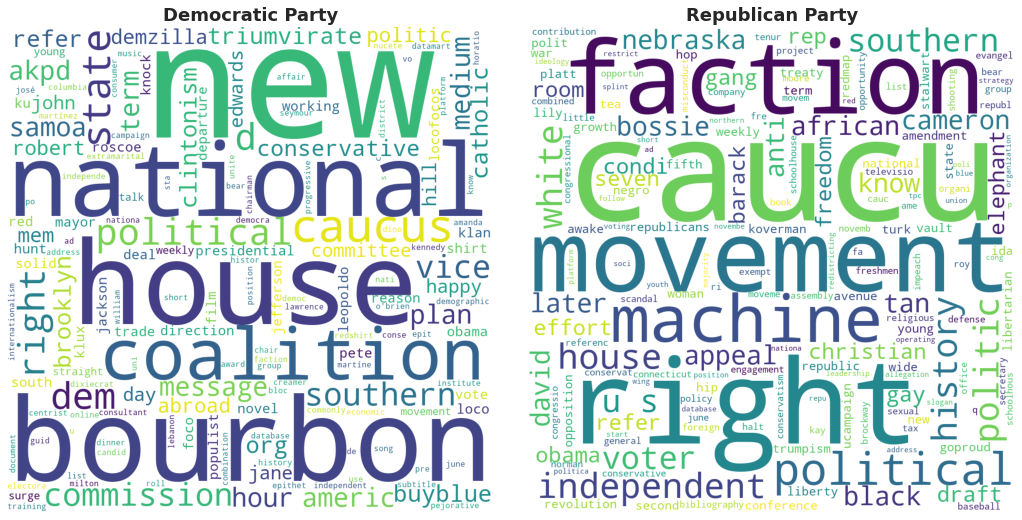

In [ ]:
# Create stopword list and update it with party names
stopwords = set(STOPWORDS)
# stopwords to be added
stopwords_list = ["democratic", "democratic party", "democrat", "democrats",
                  "republican", "republican party", "united states", "party",
                  "american", "america", "united", "states"]
stopwords.update(stopwords_list)


# Create wordclouds
wordcloud_democrats = WordCloud(width = 1000, height = 1000,
                      background_color='white',
                      stopwords=stopwords,
                      min_font_size=10).generate(democrats_df["full_text_lemmatized_stopword_removed"].to_string())
wordcloud_republican = WordCloud(width = 1000, height = 1000,
                      background_color='white',
                      stopwords=stopwords,
                      min_font_size=10).generate(republican_df["full_text_lemmatized_stopword_removed"].to_string())



# plot the wordcloud image
fig, ax = plt.subplots(1, 2, figsize = (15, 15))
ax[0].imshow(wordcloud_democrats)
ax[0].set_title("Democratic Party", fontdict={'fontsize': 18, 'fontweight' : 'bold'})
ax[0].axis("off")

ax[1].imshow(wordcloud_republican)
ax[1].set_title("Republican Party", fontdict={'fontsize': 18, 'fontweight' : 'bold'})
ax[1].axis("off")
plt.tight_layout(pad = 3)
plt.show()

For the Democratic Party, we see that *bourbon, national, new, and house* are mentioned the most. For the Republican Party we see *faction, right, movement, and caucu* which all correspond to rather politically used words. However, it's hard to get a better grasp of the differences between the wiki pages as firstly, we lack context of the words used the most, and lastly, we still have very similar words in both word clouds (e.g. caucus & caucu, right & right, house & house). Let us, therefore, inspect the vocabulary range next and see if we can filter out words that are only used by either of the parties.

In [ ]:
# Create scatterplot
fig = px.scatter(us_party_df, y="vocabulary_range", x="text_length",
                 color='category_name',
                 custom_data = ['title', 'category_name', 'vocabulary_range'],
                 title="Vocabulary range compared to text length",
                 template="seaborn",
                 color_discrete_map={"Democratic Party": "#0872AE",
                                         "Republican Party": "#BD2821"}, 
                 opacity=0.6)
  
fig.update_layout(
    legend_title="Party",
    xaxis_title="Text Length",
    yaxis_title="Vocabulary Range")

fig.update_traces(
    hovertemplate="<br>".join([
        "Party: %{customdata[1]}",
        "Text Length: %{x}",
        "Vocabulary Range: %{customdata[2]}",
        "Title of wiki page: %{customdata[0]}"
    ]),
    marker=dict(size=12)
)

fig.show()

We see that the vocabulary range increases with the text length (words used). The relationship seems to be linear in the lower points, with some outliers in higher values. However, the points seem to be very close for both parties. Let's take a look at the overall vocabulary range.

In [ ]:
# Concatenate text per category
democrats_text = democrats_df["full_text_lemmatized"].str.cat(sep=" ")
republican_text = republican_df["full_text_lemmatized"].str.cat(sep=" ")

# Create dataframe
republican_dict = {"Party": "Republican Party", "Text": republican_text}
democrat_dict = {"Party": "Democratic Party", "Text": democrats_text}
whole_text_df = pd.DataFrame([republican_dict, democrat_dict])

# Calulate vocabulary range
whole_text_df["vocabulary_range"] = whole_text_df["Text"].apply(lambda x: len({word for word in x.split() if word.isalnum()}))

In [ ]:
# Create boxplot
fig = px.bar(whole_text_df, x="Party", y="vocabulary_range",
             color='Party',
             title="Vocabulary range",
             template="seaborn",
             color_discrete_map={"Democratic Party": "#0872AE",
                                 "Republican Party": "#BD2821"},
             opacity=0.8)


fig.update_layout(yaxis_title="Vocabulary Range")

fig.update_traces(
    hovertemplate="<br>".join([
        "Party: %{x}",
        "Vocabulary Range: %{y}"
    ])
    )

fig.show()

Indeed, both parties have almost the same vocabulary range. Since we are specifically interested in the differences, let's inspect the words that are only used by either of the parties.

In [ ]:
# Get full text per category
democrats_dict = {"Category": "Democratic Party",
                  "Text": democrats_df["full_text_lemmatized"].str.cat(sep=" ")}
republican_dict = {"Category": "Republican Party",
                  "Text": republican_df["full_text_lemmatized"].str.cat(sep=" ")}

# Crate dataframes
democrats_words = pd.DataFrame(democrats_dict, index=[0])
republican_words = pd.DataFrame(republican_dict, index=[0])

# Add vocabulary per category
democrats_words["vocabulary"] = democrats_words["Text"].apply(lambda x: list({word for word in x.split() if word.isalnum()}))
republican_words["vocabulary"] = republican_words["Text"].apply(lambda x: list({word for word in x.split() if word.isalnum()}))

# Define funtion to get word difference per category (words that are not used by both categories)
def get_unique_words(words_list, comparison_list):
  """
  Takes in a list of words and returns list of difference in 
  words that are not used in comparision list.
  """
  unique_words = []
  for word in words_list:
    if word in comparison_list:
      continue
    else:
      unique_words.append(word)
  
  return unique_words


In [ ]:
# Apply function to get list of unique words per party
democrats_unique_words = get_unique_words(democrats_words["vocabulary"][0], republican_words["vocabulary"][0])
republican_unique_words = get_unique_words(republican_words["vocabulary"][0], democrats_words["vocabulary"][0])

# Total Vocabulary
total_democrats = whole_text_df[whole_text_df["Party"] == "Democratic Party"]["vocabulary_range"]
total_republican = whole_text_df[whole_text_df["Party"] == "Republican Party"]["vocabulary_range"]

print(f"Number of unique words for democrat wiki pages: {len(democrats_unique_words)}")
print(f"Percentage of words that are only used in democrat wiki pages: {float(len(democrats_unique_words)/total_democrats * 100):.2f} %", end="\n\n")
print(f"Number of unique words for republican wiki pages: {len(republican_unique_words)}")
print(f"Percentage of words that are only used in republican wiki pages: {float(len(republican_unique_words)/total_republican * 100):.2f} %")

Number of unique words for democrat wiki pages: 2535
Percentage of words that are only used in democrat wiki pages: 44.44 %

Number of unique words for republican wiki pages: 2615
Percentage of words that are only used in republican wiki pages: 45.21 %


We see that around 45% of the used words for either party are not used in the wiki pages of the other party. Let us create a word cloud for these words. 

In [ ]:
# Define function to count number of occurences of unique words
def count_unique_words(unique_words_list, text):
  """
  Counts the number of occurances of words in a text.
  """
  counts = dict()
  text_list = text.split()

  for unique_word in unique_words_list:
    for word in text_list:
      if unique_word == word:
        if word in counts:
          counts[word] += 1
        else:
          counts[word] = 1

  return counts

# Apply function to get number of occurances for unique word
democrats_unique_words_count = count_unique_words(democrats_unique_words, democrats_words["Text"][0])
republican_unique_words_count = count_unique_words(republican_unique_words, republican_words["Text"][0])


In [ ]:
# Create text with number of every unique word
# Define function
def text_generator(words_dict):
  """
  Takes in dict and returns a string consisting or value times key.
  """
  words_list = []
  for word, count in words_dict.items():
    for num in range(count):
      words_list.append(word)

  return " ".join(words_list)

# Apply function to unique words
democrats_unique_text = text_generator(democrats_unique_words_count)
republican_unique_text = text_generator(republican_unique_words_count)

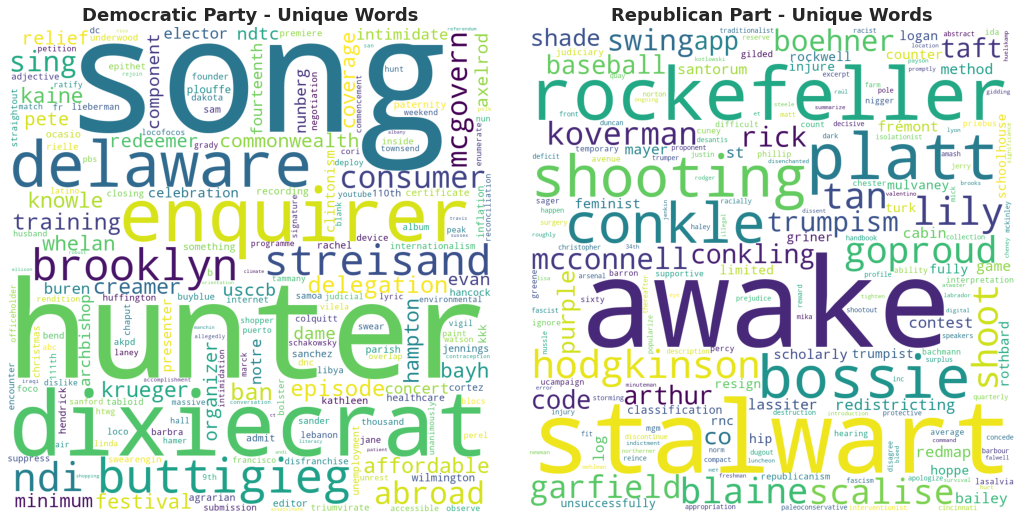

In [ ]:
# Create word clouds with unique words per category
# Create wordclouds
wordcloud_democrats = WordCloud(width = 1000, height = 1000,
                      background_color='white',
                      stopwords=stopwords,
                      collocations=False, # ignore collocations as same words are written after each other
                      min_font_size=10).generate(democrats_unique_text)
wordcloud_republican = WordCloud(width = 1000, height = 1000,
                      background_color='white',
                      stopwords=stopwords,
                      collocations=False, # ignore collocations as same words are written after each other
                      min_font_size=10).generate(republican_unique_text)



# plot the wordcloud image
fig, ax = plt.subplots(1, 2, figsize = (15, 15))
ax[0].imshow(wordcloud_democrats)
ax[0].set_title("Democratic Party - Unique Words", fontdict={'fontsize': 18, 'fontweight' : 'bold'})
ax[0].axis("off")

ax[1].imshow(wordcloud_republican)
ax[1].set_title("Republican Part - Unique Words", fontdict={'fontsize': 18, 'fontweight' : 'bold'})
ax[1].axis("off")
plt.tight_layout(pad = 3)
plt.show()

In [ ]:
# How many times is the most frequent uniqe word used
print("The most used unique words per party are:")
print(f"Democrats: '{max(democrats_unique_words_count, key=democrats_unique_words_count.get)}' was used {democrats_unique_words_count[max(democrats_unique_words_count, key=democrats_unique_words_count.get)]} times")
print(f"Republican: '{max(republican_unique_words_count, key=republican_unique_words_count.get)}' was used {republican_unique_words_count[max(republican_unique_words_count, key=republican_unique_words_count.get)]} times")

The most used unique words per party are:
Democrats: 'song' was used 49 times
Republican: 'awake' was used 35 times


> 💡 **Key insight:** 
>
> **Democratic Party:** We see that *song* is the most used word for wiki pages of the Democratic Party that was not used one in a wiki page of the Republican Party. This can be lead back to the song ["Happy Days Are Here Again"](https://en.wikipedia.org/wiki/Happy_Days_Are_Here_Again), which is the unofficial song of the Democratic Party. This also implicitly means that the Republican Party does not have a song or is at least not that proud thereof that they have it mentioned in one of their wiki pages.
>
> **Republican Party:** For the Republican Party the word *awake* results as the top word. Inspecting the articles leads to the conclusion that this article comes from a specific wiki page about [Wide Awakes](https://en.wikipedia.org/wiki/Wide_Awakes) a youth organization and later paramilitary organization of the Republican Party during the 1860 elections. This is however not what we would think of when we first see the word itself. However, since we lemmatized and lowereded the letters in our text, *Awakes* was turned into *awake* and the wiki pages of the Democratic Party used the word *wide* we got the following result. To only try to analyze a word by itself can be dangerous, as context can get lost in the words before or after. To solve this problem we can work with N-Grams that help us analyze a number of n-consecutive words in a text.

#### N-Grams

N-Grams are a sequence of n-consecutive words in a text. With their help, we will next take a closer look at the most common Bigrams (two consecutive words) and Trigrams (three consecutive words) in the wiki pages of both of our categories.

To do this, we will use `nltk` (see documentation https://www.nltk.org/api/nltk.util.html?highlight=ngrams#nltk.util.ngrams).

##### Bigrams

In [ ]:
# Remove symbols and punctuation in texts
democrats_words["Text_without_punct_symbols"] = democrats_words["Text"].apply(lambda x: " ".join(word for word in x.split() if word.isalnum()))
republican_words["Text_without_punct_symbols"] = republican_words["Text"].apply(lambda x: " ".join(word for word in x.split() if word.isalnum()))

# Remove stopwords with function we create earlier
democrats_words["Text_without_punct_stopwords"] = democrats_words["Text_without_punct_symbols"].apply(lambda x: stop_word_remover(x))
republican_words["Text_without_punct_stopwords"] = republican_words["Text_without_punct_symbols"].apply(lambda x: stop_word_remover(x))

In [ ]:
# Get bigram counts and create dataframes
n = 2
# Democrats
tokens = nltk.word_tokenize(democrats_words["Text_without_punct_stopwords"][0])
democrat_bigram_counts = pd.Series(nltk.ngrams(tokens, n)).value_counts()[:10]
democrats_bigram_df = pd.DataFrame(democrat_bigram_counts, columns=["Count"]).reset_index().rename(columns={'index': 'Bigrams'})
democrats_bigram_df["category_name"] = "Democratic Party"
# Republican
tokens = nltk.word_tokenize(republican_words["Text_without_punct_stopwords"][0])
republican_bigram_counts = pd.Series(nltk.ngrams(tokens, n)).value_counts()[:10]
republican_bigram_df = pd.DataFrame(republican_bigram_counts, columns=["Count"]).reset_index().rename(columns={'index': 'Bigrams'})
republican_bigram_df["category_name"] = "Republican Party"

In [ ]:
# Take a look at the dataframe
democrats_bigram_df

,Bigrams,Count,category_name
0,"(democratic, party)",224,Democratic Party
1,"(united, states)",151,Democratic Party
2,"(republican, party)",62,Democratic Party
3,"(civil, right)",60,Democratic Party
4,"(new, york)",59,Democratic Party
5,"(south, carolina)",58,Democratic Party
6,"(presidential, election)",53,Democratic Party
7,"(north, carolina)",40,Democratic Party
8,"(red, shirt)",40,Democratic Party
9,"(catholic, democrats)",38,Democratic Party


In [ ]:
# Take a look at the dataframe
republican_bigram_df

,Bigrams,Count,category_name
0,"(republican, party)",199,Republican Party
1,"(united, states)",130,Republican Party
2,"(political, donation)",66,Republican Party
3,"(presidential, election)",54,Republican Party
4,"(civil, right)",52,Republican Party
5,"(halt, political)",51,Republican Party
6,"(new, york)",49,Republican Party
7,"(donation, review)",39,Republican Party
8,"(southern, strategy)",38,Republican Party
9,"(donald, trump)",37,Republican Party


In [ ]:
# Democrats - Create barplot of 10 most common words
fig = px.bar(democrats_bigram_df, x="Bigrams", y="Count",
             color="Bigrams",
             title="Most Common Bigrams Democratic Party",
             template="seaborn",
             opacity=0.8,
             width=800, height=400
              )
fig.update_traces(
    hovertemplate="<br>".join([
        "Bigram: %{x}",
        "Count: %{y}"
    ]),
    marker=dict(color='#0872AE')
    )

fig.update_xaxes(type='category')
fig.update_layout(showlegend=False)
fig.update_layout({'xaxis':{'tickangle': 60}})

fig.show()

# Republican - Create barplot of 10 most common words
fig = px.bar(republican_bigram_df, x="Bigrams", y="Count",
             color="Bigrams",
             title="Most Common Bigrams Republican Party",
             template="seaborn",
             opacity=0.8,
             width=800, height=400
              )
fig.update_traces(
    hovertemplate="<br>".join([
        "Bigram: %{x}",
        "Count: %{y}"
    ]),
    marker=dict(color='#BD2821')
    )

fig.update_xaxes(type='category')
fig.update_layout(showlegend=False)
fig.update_layout({'xaxis':{'tickangle': 60}})

fig.show()


Inspecting the Bigrams shows that both parties have their own party name and the united states as the most common bigrams. For the Democratic Party, we see that they also mention the Republican Party a lot, which is not the case for the Republican Party. The wiki pages of them on the other hand seem to write a lot about political donations, which is not the case for the Democratic Party. 

Let's continues by building and inspecting Trigrams.

##### Trigrams

In [ ]:
# Get bigram counts and create dataframes
n = 3
# Democrats
tokens = nltk.word_tokenize(democrats_words["Text_without_punct_stopwords"][0])
democrat_trigram_counts = pd.Series(nltk.ngrams(tokens, n)).value_counts()[:10]
democrats_trigram_df = pd.DataFrame(democrat_trigram_counts, columns=["Count"]).reset_index().rename(columns={'index': 'Trigrams'})
democrats_trigram_df["category_name"] = "Democratic Party"
# Republican
tokens = nltk.word_tokenize(republican_words["Text_without_punct_stopwords"][0])
republican_trigram_counts = pd.Series(nltk.ngrams(tokens, n)).value_counts()[:10]
republican_trigram_df = pd.DataFrame(republican_trigram_counts, columns=["Count"]).reset_index().rename(columns={'index': 'Trigrams'})
republican_trigram_df["category_name"] = "Republican Party"

In [ ]:
# Take a look at the dataframe
democrats_trigram_df

,Trigrams,Count,category_name
0,"(party, united, states)",19,Democratic Party
1,"(democratic, national, convention)",17,Democratic Party
2,"(president, united, states)",14,Democratic Party
3,"(democratic, party, united)",14,Democratic Party
4,"(united, states, democratic)",14,Democratic Party
5,"(civil, right, act)",13,Democratic Party
6,"(states, democratic, party)",13,Democratic Party
7,"(new, york, city)",11,Democratic Party
8,"(southern, united, states)",11,Democratic Party
9,"(democratic, national, committee)",11,Democratic Party


In [ ]:
# Take a look at the dataframe
republican_trigram_df

,Trigrams,Count,category_name
0,"(halt, political, donation)",49,Republican Party
1,"(political, donation, review)",39,Republican Party
2,"(resume, political, donation)",15,Republican Party
3,"(party, united, states)",15,Republican Party
4,"(tea, party, caucus)",13,Republican Party
5,"(republican, national, committee)",13,Republican Party
6,"(united, states, presidential)",13,Republican Party
7,"(states, presidential, election)",12,Republican Party
8,"(weekly, republican, address)",12,Republican Party
9,"(united, states, house)",11,Republican Party


In [ ]:
# Democrats - Create barplot of 10 most common words
fig = px.bar(democrats_trigram_df, x="Trigrams", y="Count",
             color="Trigrams",
             title="Most Common Trigrams Democratic Party",
             template="seaborn",
             opacity=0.8,
             width=800, height=400
              )
fig.update_traces(
    hovertemplate="<br>".join([
        "Trigram: %{x}",
        "Count: %{y}"
    ]),
    marker=dict(color='#0872AE')
    )

fig.update_xaxes(type='category')
fig.update_layout(showlegend=False)
fig.update_layout({'xaxis':{'tickangle': 60}})

fig.show()

# Republican - Create barplot of 10 most common words
fig = px.bar(republican_trigram_df, x="Trigrams", y="Count",
             color="Trigrams",
             title="Most Common Trigrams Republican Party",
             template="seaborn",
             opacity=0.8,
             width=800, height=400
              )
fig.update_traces(
    hovertemplate="<br>".join([
        "Trigram: %{x}",
        "Count: %{y}"
    ]),
    marker=dict(color='#BD2821')
    )

fig.update_xaxes(type='category')
fig.update_layout(showlegend=False)
fig.update_layout({'xaxis':{'tickangle': 60}})

fig.show()


> 💡 **Key insight:** From the Trigrams, we see that the Democratic Party writes most commonly about *parties in the united states*, *democratic national convention*, and the *president of the united states*. Whereas a main topic for the Republican Party seems to be centered on political donations, whether it's the halt, review, or resumption of those. Additionally *New York City* and the *Southern United States* are mentioned frequently in the wiki pages of the Democratic Party, which correspond to locations and places.

Analyzing the entities as locations or places seems therefore to be interesting. Before we do this, let us first take a look at the specific part of speech of every word in a wiki page by inspecting the part of speech (POS) of the words.

#### Part of Speech (POS Tagging)

POS tagging helps us to categorize words into their word types. Let's see if we find any differences between both parties.

We can apply POS tagging by using `spacy` (see: https://spacy.io/usage/linguistic-features).

In [ ]:
# Take random text and show POS
np.random.seed(47)

random_article_index = np.random.choice(len(us_party_df)+1)
random_article = us_party_df.iloc[random_article_index]

print(f"From the random chosen page '{random_article['title']}' of the category '{random_article['category_name']}': \n")
# Crate doc and print first few tokens (see: https://spacy.io/usage/linguistic-features)
doc = nlp(random_article['text'])
for token in doc[:21]:
  print(f"Word: {token.text} --> POS: {token.pos_} ({spacy.explain(token.pos_)})\n")

From the random chosen page 'Brooklyn Democratic Party' of the category 'Democratic Party': 

Word: Structure --> POS: NOUN (noun)

Word: The --> POS: DET (determiner)

Word: New --> POS: PROPN (proper noun)

Word: York --> POS: PROPN (proper noun)

Word: Election --> POS: PROPN (proper noun)

Word: Law --> POS: PROPN (proper noun)

Word: defines --> POS: VERB (verb)

Word: the --> POS: DET (determiner)

Word: structure --> POS: NOUN (noun)

Word: of --> POS: ADP (adposition)

Word: political --> POS: ADJ (adjective)

Word: parties --> POS: NOUN (noun)

Word: and --> POS: CCONJ (coordinating conjunction)

Word: requires --> POS: VERB (verb)

Word: each --> POS: DET (determiner)

Word: party --> POS: NOUN (noun)

Word: to --> POS: PART (particle)

Word: have --> POS: VERB (verb)

Word: county --> POS: NOUN (noun)

Word: committees --> POS: NOUN (noun)

Word: . --> POS: PUNCT (punctuation)



In [ ]:
# Visualizing the dependency phrase (see: https://spacy.io/usage/visualizers#jupyter)
doc = nlp(random_article['text'])
spacy.displacy.render(doc[:21], style="dep", jupyter=True) 

Thanks to `spacy` we can easily get the part of speech for every word and can additionally visualize the dependency of words within a phrase.

Let us now visualize the number of used tags in the wiki pages of every party.

In [ ]:
# Create functions that tags every word
def create_pos_tag_df(text_column, category_name):
  """
  Takes in a Text and creates a dataframe consisting 
  of every word and it's related POS tag.
  """
  pos_tag_list = []
  for index, text in text_column.iteritems():
    doc = nlp(text)
    for token in doc:
      pos_tag_list.append({"Word": token.text, "POS": token.pos_, "Party": category_name})

  pos_tag_df = pd.DataFrame(pos_tag_list)

  return pos_tag_df  

In [ ]:
# Create dataframes per party
democrats_pos_tag_df = create_pos_tag_df(democrats_df['text'], category_name="Democratic Party")
republican_pos_tag_df = create_pos_tag_df(republican_df['text'], category_name="Republican Party")

# Aggregate dataframes for visualisation - take top 10 POS per Party
democrats_agg_pos_df = democrats_pos_tag_df.groupby('POS')['POS'].count().\
      reset_index(name='Count').sort_values('Count', ascending=False).head(10)
republican_agg_pos_df = republican_pos_tag_df.groupby( 'POS')['POS'].count().\
      reset_index(name='Count').sort_values('Count', ascending=False).head(10)

In [ ]:
# Democrats - Create barplot of 10 most common POS tags
fig = px.bar(democrats_agg_pos_df, x="POS", y="Count",
             title="Most Common POS tags - Democratic Party",
             template="seaborn",
             opacity=0.8,
             width=800, height=400
              )
fig.update_traces(
    hovertemplate="<br>".join([
        "POS: %{x}",
        "Count: %{y}"
    ]),
    marker=dict(color='#0872AE')
    )

fig.update_xaxes(type='category')
fig.update_layout(showlegend=False)
fig.update_layout({'xaxis':{'tickangle': 60}})

fig.show()

# Republican - Create barplot of 10 most common POS tags
fig = px.bar(republican_agg_pos_df, x="POS", y="Count",
             title="Most Common POS tags - Republican Party",
             template="seaborn",
             opacity=0.8,
             width=800, height=400
              )
fig.update_traces(
    hovertemplate="<br>".join([
        "POS: %{x}",
        "Count: %{y}"
    ]),
    marker=dict(color='#BD2821')
    )

fig.update_xaxes(type='category')
fig.update_layout(showlegend=False)
fig.update_layout({'xaxis':{'tickangle': 60}})

fig.show()

A first overview of the different tags does not make any differences visible, as both parties have the same most commonly used POS tags. However, we can now take a closer look at the used verbs in order to understand what actions occur or occured in the wiki pages.

In [ ]:
# Let's take a look at the most used VERB
# Aggregate dataframe to show most common used VERB
democrats_verb_df = democrats_pos_tag_df[democrats_pos_tag_df['POS'] == 'VERB'].copy()
democrats_agg_verb_df = democrats_verb_df.groupby('Word')['Word'].count()\
      .reset_index(name='Count').sort_values(['Count'], ascending=False).head(10)

republican_verb_df = republican_pos_tag_df[republican_pos_tag_df['POS'] == 'VERB'].copy()
republican_agg_verb_df = republican_verb_df.groupby('Word')['Word'].count()\
      .reset_index(name='Count').sort_values(['Count'], ascending=False).head(10)

In [ ]:
# Democrats - Create barplot of 10 most common verbs
fig = px.bar(democrats_agg_verb_df, x="Word", y="Count",
             title="Most Common Verbs - Democratic Party",
             template="seaborn",
             opacity=0.8,
             width=800, height=400
              )
fig.update_traces(
    hovertemplate="<br>".join([
        "Verb: %{x}",
        "Count: %{y}"
    ]),
    marker=dict(color='#0872AE')
    )

fig.update_xaxes(type='category')
fig.update_layout(showlegend=False)
fig.update_layout({'xaxis':{'tickangle': 60}})

fig.show()

# Republican - Create barplot of 10 most common verbs
fig = px.bar(republican_agg_verb_df, x="Word", y="Count",
             title="Most Common Verbs - Republican Party",
             template="seaborn",
             opacity=0.8,
             width=800, height=400
              )
fig.update_traces(
    hovertemplate="<br>".join([
        "Verb: %{x}",
        "Count: %{y}"
    ]),
    marker=dict(color='#BD2821')
    )

fig.update_xaxes(type='category')
fig.update_layout(showlegend=False)
fig.update_layout({'xaxis':{'tickangle': 60}})

fig.show()

> 💡 **Key insight:** We see that the wiki pages of the Democratic Party write the most about things that someone won or about situations of use and support. With the word *won* we see that it was used more than twice as much in wiki pages of the Democratic Party as in wiki pages of the Republican Party. Winning is therefore a central action in the wiki pages of the Democratic Party. Contrarily, for the wiki pages of the Republican Party it's the halting of something, which can be led back to our insight from the Trigrams about halting political donations. 


We've come far by now. As the last step, let us inspect and analyze the entities mentioned in the wiki pages.

#### Named Entity

Named entity helps us identify people, locations, organizations, and more in a text. After we have identified the most common action described in the wiki pages for every party, we can now additionally look for the people and major locations of the pages and see if there are visible differences.

We can search for Named Entities by using `spacy` as well (see: https://spacy.io/usage/visualizers#ent).

In [ ]:
# Take random text and show Entities
np.random.seed(21)

random_article_index = np.random.choice(len(us_party_df)+1)
random_article = us_party_df.iloc[random_article_index]

print(f"From the random chosen page '{random_article['title']}' of the category '{random_article['category_name']}': \n")
# Crate doc and print first few tokens (see: https://spacy.io/usage/visualizers#ent)
doc = nlp(random_article['text'])
for word in doc.ents[:10]:
  print(f"Word: {word.text} --> Entity: {word.label_} ({spacy.explain(word.label_)})\n")

From the random chosen page 'Factions in the Republican Party (United States)' of the category 'Republican Party': 

Word: Barack Obama --> Entity: PERSON (People, including fictional)

Word: the Republican Party --> Entity: ORG (Companies, agencies, institutions, etc.)

Word: Republican --> Entity: NORP (Nationalities or religious or political groups)

Word: Tea Party --> Entity: ORG (Companies, agencies, institutions, etc.)

Word: 2012 --> Entity: DATE (Absolute or relative dates or periods)

Word: The New York Times --> Entity: ORG (Companies, agencies, institutions, etc.)

Word: six --> Entity: CARDINAL (Numerals that do not fall under another type)

Word: the Republican Party --> Entity: ORG (Companies, agencies, institutions, etc.)

Word: Main Street Voters --> Entity: ORG (Companies, agencies, institutions, etc.)

Word: Christian Conservatives --> Entity: NORP (Nationalities or religious or political groups)



In [ ]:
# Visualizing the named entities
doc = nlp(random_article['text'])
spacy.displacy.render(doc[:39], style="ent", jupyter=True) 

Inspecting a subset of the text shows that we can visualize the named entities in a text very well. This will definitely help us find the persons mentioned in the wiki pages. Let us continue by inspecting the most used entities.

In [ ]:
# Create functions that marks entities
def create_named_entity_df(text_column, category_name):
  """
  Takes in a Text and creates a dataframe consisting 
  of named entities in the text.
  """
  named_entity_list = []
  for index, text in text_column.iteritems():
    doc = nlp(text)
    for token in doc.ents:
      named_entity_list.append({"Word": token.text, "Named_entity": token.label_, "Party": category_name})

  named_entity_df = pd.DataFrame(named_entity_list)

  return named_entity_df 

In [ ]:
# Create dataframes per party
democrats_named_entity_df = create_named_entity_df(democrats_df['text'], category_name="Democratic Party")
republican_named_entity_df = create_named_entity_df(republican_df['text'], category_name="Republican Party")

# Aggregate dataframes for visualisation - take top 10 POS per Party
democrats_agg_named_entity_df = democrats_named_entity_df.groupby('Named_entity')['Named_entity'].count().\
      reset_index(name='Count').sort_values('Count', ascending=False).head(10)
republican_agg_named_entity_df = republican_named_entity_df.groupby('Named_entity')['Named_entity'].count().\
      reset_index(name='Count').sort_values('Count', ascending=False).head(10)

In [ ]:
# Democrats - Create barplot of 10 most common named entities
fig = px.bar(democrats_agg_named_entity_df, x="Named_entity", y="Count",
             title="Most Common Named Entities - Democratic Party",
             template="seaborn",
             opacity=0.8,
             width=800, height=400,
             labels=dict(Named_entity="Named Entity")
              )
fig.update_traces(
    hovertemplate="<br>".join([
        "Named Entity: %{x}",
        "Count: %{y}"
    ]),
    marker=dict(color='#0872AE')
    )

fig.update_xaxes(type='category')
fig.update_layout(showlegend=False)
fig.update_layout({'xaxis':{'tickangle': 60}})

fig.show()

# Republican - Create barplot of 10 most common named entities
fig = px.bar(republican_agg_named_entity_df, x="Named_entity", y="Count",
             title="Most Common Named Entities - Republican Party",
             template="seaborn",
             opacity=0.8,
             width=800, height=400,
             labels=dict(Named_entity="Named Entity")
              )
fig.update_traces(
    hovertemplate="<br>".join([
        "Named Entity: %{x}",
        "Count: %{y}"
    ]),
    marker=dict(color='#BD2821')
    )

fig.update_xaxes(type='category')
fig.update_layout(showlegend=False)
fig.update_layout({'xaxis':{'tickangle': 60}})

fig.show()

For both parties, persons seem to be the most commonly named entity. Therefore, let us see who they are.

In [ ]:
# Let's take a look at the most mentioned persons
# Aggregate dataframe to show most common mentioned persons
democrats_person_df = democrats_named_entity_df[democrats_named_entity_df['Named_entity'] == 'PERSON'].copy()
democrats_agg_person_df = democrats_person_df.groupby('Word')['Word'].count()\
      .reset_index(name='Count').sort_values(['Count'], ascending=False).head(10)

republican_person_df = republican_named_entity_df[republican_named_entity_df['Named_entity'] == 'PERSON'].copy()
republican_agg_person_df = republican_person_df.groupby('Word')['Word'].count()\
      .reset_index(name='Count').sort_values(['Count'], ascending=False).head(10)

In [ ]:
# Democrats - Create barplot of 10 most common mentioned persons
fig = px.bar(democrats_agg_person_df, x="Word", y="Count",
             title="Most Common mentioned Persons - Democratic Party",
             template="seaborn",
             opacity=0.8,
             width=800, height=400
              )
fig.update_traces(
    hovertemplate="<br>".join([
        "Person: %{x}",
        "Count: %{y}"
    ]),
    marker=dict(color='#0872AE')
    )

fig.update_xaxes(type='category')
fig.update_layout(showlegend=False)
fig.update_layout({'xaxis':{'tickangle': 60}})

fig.show()

# Republican - Create barplot of 10 most common persons
fig = px.bar(republican_agg_person_df, x="Word", y="Count",
             title="Most Common mentioned Persons - Republican Party",
             template="seaborn",
             opacity=0.8,
             width=800, height=400
              )
fig.update_traces(
    hovertemplate="<br>".join([
        "Person: %{x}",
        "Count: %{y}"
    ]),
    marker=dict(color='#BD2821')
    )

fig.update_xaxes(type='category')
fig.update_layout(showlegend=False)
fig.update_layout({'xaxis':{'tickangle': 60}})

fig.show()

> 💡 **Key insights:** We see that for the Democratic Party Obama (president 2009 - 2017) and for the Republican Party Nixon (president 1969 - 1974) are the most mentioned persons. Interesting to see is that Obama and Nixon were both also mentioned in the articles of the other party. However, for Obama, we get a total count of 85 times whereas for Nixon we get 59. We therefore could say (with the assumption of equal distribution) that Obama is mentioned 0.74 times (85/114) and Nixon 0.51 (59/114) times per wiki page (114 = total number of articles). Additionally, we observe that older presidents (early 1900 or earlier) of either party are not that frequently mentioned. Additionally, we observe that the only woman that makes it into the most commonly mentioned persons is Clinton and this also only for the Democratic Party. 





## Summary

In this notebook, we extracted data from the wikipedia-api, cleaned the data and transformed them to be ready for analysis. Next, the use and analysis of `Polarity`, `TTR`, `Vocabulary Range`, `N-Grams`, `POS`and `Named Entity` helped us get a better understanding of the wiki pages and showed different ways to get a deeper understanding of text data. Central to this were the `spacy`, `textblob` and `nltk` libraries. In combination with visualisations, we were able to show similarities and difference in the two categories.

Overall, we had to look closely at the data to see differences in the wiki pages, which verify our initial assumption. Conclusively, the following insights were gathered.

* Both parties have around the same number of wiki pages and the vocabulary range is for both parties almost the same (~5'700 words). However, inspecting the vocabulary showed that around 45% of the words in the vocabulary for every party were only used by themselves and not the other party. 

* We saw that the polarity scores for the articles per party are centred around ~0.08. Based on this, we can say that they have a slight positive intent, but are written objectively.

* Both Parties mention themselves a lot. However, looking behind this, we saw the following patterns:

  **Democrats**:
    * Write most commonly about parties in the united states, democratic national convention, and the president of the united states.
    * Write about situations where someone or something was won, used, or supported.
    * Have Obama as a person mostly mentioned.

  **Republicans**:
    *  Write most commonly about political donations.
    * Write about situations where someone or something was halted.
    * Have Nixon and Bush as persons mostly mentioned.


**Where to go from here:** The analysis helped us get a better understanding of the wiki pages per category. However, not every aspect could be analyzed. One might look more closely at the most commonly mentioned organisations or central dates in the wiki pages for every Party, and compare them. Additionally, it would be interesting to take a look at the authors of the wiki pages and see how they differentiate from each other. Going beyond this it would be interesting to build an NLP model which could write new wiki pages for us or build a classification model that can categorize between the two parties (as they have some overlapping in words it would be interesting to see if we could create a model with a good accuracy score).